# Recurrent Neural Network


### From Assignment Brief:
The goal of this project is to build a next-word predictor, given a sequence of words. <br>
The input to your model is a sequence of words of any length (could be one word,
could be five words, etc.). <br>
The output of your model is a word that follows that sequence of words. <br>
In principle, given an input to your model, you can ask your model to predict the next
ten words, by asking your model to predict the next word ten times. <br>
To test your model, you must apply the following ten example sequences of words as inputs: <br>
You can ask your model to predict the next ten words, given each input. For example: (Seed text **bolded**) <br><br>
Model 1: <br>
**embrace each day** for morning's potential is a blank canvas seize it with <br>
**radiate some** gratitude and watch as the universe conspires to bring you <br>
**believe that** yourself and let your heart's whispers guide you to your <br>
**life's actual purpose is** a chance to learn to grow and to embrace the <br>
**dance through each and every** one chapter of life to the next world your nature <br>
**let your time and energy** so brightly that it eclipses even the darkest of days <br>
**every person is** of kindness sends ripples of positivity throughout the universe of <br>
**our country Singapore is** through storms knowing that your steps create the path to <br>
**planet earth is** through challenges like a breeze through the trees leaving a <br>
**morning and evening would make it** the chisels that sculpt you into a masterpiece of strength <br>

Model 2:<br>
**embrace each day** they bring the thunder that clears the path to your<br>
**radiate some** positivity illuminating the world with a light that banishes darkness<br>
**believe that** yourself and let your inner light outshine any darkness around<br>
**life's actual purpose is** a wildflower spreading love's fragrance far and wide and majesty<br>
**dance through each and every** from one chapter of life to the next next hues<br>
**let your time and energy** so hold mysteries waiting to be explored revealing hidden wonders<br>
**every person is** you nurture blooms into a garden of meaningful relationships relationships<br>
**our country Singapore is** is a testament to the city's ambition and resilience and<br>
**planet earth is** sparkles a reflection of the city's ambition to reach new<br>
**morning and evening would make it** a tapestry of flavors weaving a story of cultural fusion<br>

In [1]:
seed_texts = [
    'embrace each day',
    'radiate some',
    'believe that',
    "life's actual purpose is",
    'dance through each and every',
    'let your time and energy',
    'every person is',
    'our country Singapore is',
    'planet earth is',
    'morning and evening would make it'
]

In [2]:
import os
from tqdm.notebook import tqdm
import random
import warnings
import re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

pd.set_option('display.max_colwidth', None)

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import spacy

nlp = spacy.load("en_core_web_sm")

from bert_score import score

import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

In [5]:
!nvidia-smi

Wed Nov 22 21:29:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P8              10W / 200W |   2728MiB / 12282MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate, TextVectorization, Embedding, Bidirectional, Attention, GaussianNoise
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, SimpleRNNCell, StackedRNNCells, LSTMCell, GRUCell, RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [7]:
import visualkeras

In [8]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)
random.seed(42)

# Exploratory Data Analysis

The dataset consists of 1000 training text samples.

In [9]:
df = pd.read_csv("data/train.csv")
eda_df = df.copy()

In [10]:
eda_df.head()

,Quotes
0,Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
1,Embrace challenges; they are the stepping stones to your greatest victories.
2,Embrace the rhythm of life and let it dance through your soul.
3,"Embrace kindness, for it has the power to change the world one heart at a time."
4,"Embrace the journey, for it leads to the destination of your dreams."


In [11]:
eda_df.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracing what is."
freq,5


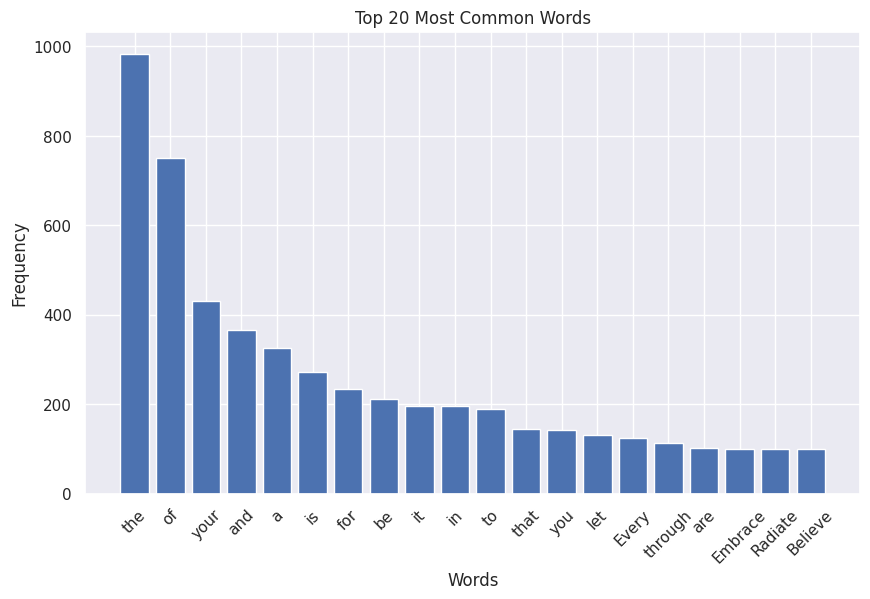

In [12]:
from collections import Counter

# Assuming 'sentences' is a list of sentences in your dataset
words = [word for sentence in eda_df["Quotes"] for word in sentence.split()]
word_freq = Counter(words)
top_20_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [13]:
sentence_lengths = [len(sentence.split()) for sentence in eda_df["Quotes"]]
print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
print("Maximum sentence length:", max(sentence_lengths))
print("Minimum sentence length:", min(sentence_lengths))

Average sentence length: 11.865
Maximum sentence length: 35
Minimum sentence length: 7


## Preprocessing

In [14]:
train, test = train_test_split(df["Quotes"], test_size=0.2, random_state=23)
train, validation = train_test_split(train, test_size=2/8, random_state=23)

In [15]:
df["Quotes"]

0                                                      Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
1                                                                Embrace challenges; they are the stepping stones to your greatest victories.
2                                                                              Embrace the rhythm of life and let it dance through your soul.
3                                                             Embrace kindness, for it has the power to change the world one heart at a time.
4                                                                        Embrace the journey, for it leads to the destination of your dreams.
                                                                        ...                                                                  
995                                        With an open heart, welcome the opportunities and possibilities that this morning brings your way.
996   

In [16]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
import re

contractions = {
    "'s": "is",
    "'ve": "have",
    "'ll": "will"
}

def tokenize_regex(sentence, remove_spaces=True, replace_contraction=False):
    if remove_spaces:
        pattern = f'[{re.escape(string.punctuation)}]'
        split_result_spaces = re.split(f'({pattern})', sentence)
        split_result = []
        for res in split_result_spaces:
            split_result += res.split(" ")
    else:
        pattern = f'[{re.escape(string.punctuation)} ]'
        split_result = re.split(f'({pattern})', sentence)

    result = [s for s in split_result if s]

    for i in range(len(result)-1, 0, -1):
        if contractions.get(result[i-1]+result[i]):
            if replace_contraction:
                result[i-1] = contractions.get(result[i-1]+result[i])
            else:
                result[i-1] = result[i-1]+result[i]
            result.pop(i)

    return result

sentence = "Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy."
result = tokenize_regex(sentence)
print(result)

['Embrace', 'the', 'beauty', 'of', 'every', 'sunrise', ';', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy', '.']


In [18]:
def remove_punctuation(sentence):
    PUNC = [";", ".", ",", ":", "?", "!", "\n", "\t", "'", '"', "-"]
    output = []
    for word in sentence:
        if word not in PUNC:
            output.append(word)
    return output

def keep_joint(sentence, joiner):
    output = [sentence[0]]
    for i, word in enumerate(sentence[1:]):
        if joiner in word:
            output.pop()
            output.append(sentence[i-1]+word)
            print(i, sentence)
        else:
            output.append(word)
    return output

def remove_contractions(sentence):
    contractions = {
        "'s": "is",
        "'ve": "have",
        "'ll": "will"
    }
    output = []
    for word in sentence:
        if word in contractions:
            word = contractions[word]
        output.append(word)
    # print(output)
    return output

def clean_sentences(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = remove_punctuation(sentence)
        # sentences[i] = remove_contractions(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

def clean_sentences_for_input(sentences):
    # for i, sentence in enumerate(sentences):
    #     # sentences[i] = remove_punctuation(sentence)
    #     sentences[i] = remove_contractions(sentence)
    #     # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

In [19]:
tokenized_quotes = [tokenize_regex(sentence) for sentence in df["Quotes"]]
# tokenized_quotes = clean_sentences(tokenized_quotes)

In [20]:
all_words = []

for word in tokenized_quotes:
    all_words += word
    
print(f"Total word count: {len(all_words)}")

# for word in lemmatized_quotes:
#     all_words += word

all_words = list(set(all_words))

Total word count: 13972


In [21]:
for i in range(5):
    print(tokenized_quotes[i])

# for i in range(5):
#     print(lemmatized_quotes[i])
    
tokenizer = Tokenizer(split=" ", lower=True)
tokenizer.fit_on_texts([all_words])

total_words = len(tokenizer.word_index)
print(f"Number of unique words: {total_words}")
total_words += 1

max_sequence_length = 35

['Embrace', 'the', 'beauty', 'of', 'every', 'sunrise', ';', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy', '.']
['Embrace', 'challenges', ';', 'they', 'are', 'the', 'stepping', 'stones', 'to', 'your', 'greatest', 'victories', '.']
['Embrace', 'the', 'rhythm', 'of', 'life', 'and', 'let', 'it', 'dance', 'through', 'your', 'soul', '.']
['Embrace', 'kindness', ',', 'for', 'it', 'has', 'the', 'power', 'to', 'change', 'the', 'world', 'one', 'heart', 'at', 'a', 'time', '.']
['Embrace', 'the', 'journey', ',', 'for', 'it', 'leads', 'to', 'the', 'destination', 'of', 'your', 'dreams', '.']
Number of unique words: 1187


In [22]:
def sentences_to_data(sentences, min_len, segment, max_len=100, tokenize=True, verbose=0):
    # X_lemma = []
    X_word = []
    y = []

    tokenized_input = [[token.text for token in nlp(quote)] for quote in sentences]
    tokenized_input = clean_sentences(tokenized_input)
    
    # min_sequence_length = 4
    # max_sequence_length = 25
    if segment:
        for sequence in tokenized_input:
            for i in range(len(sequence)):
                for j in range(i+min_len, len(sequence) if len(sequence) < i+max_len else i+max_len):
                    # X_lemma.append(" ".join(sequence[i:j]))
                    X_word.append(" ".join(sequence[i:j]))
                    y.append(sequence[j])
                    if verbose > 0:
                        if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                            print(y[-1])
    else:
        for sequence in tokenized_input:
            for i in range(min_len, len(sequence) if len(sequence) < max_len else max_len):
                X_word.append(" ".join(sequence[:i]))
                y.append(sequence[i])
                if verbose > 0:
                    if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                        print(y[-1])

    sentence_lengths = [len(sentence.split(" ")) for sentence in sentences]
    if verbose > 0:
        print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
        print("Maximum sentence length:", max(sentence_lengths))
        print("Longest sentence: ", X_word[np.argmax(sentence_lengths)])
        print("Minimum sentence length:", min(sentence_lengths))

    if tokenize:
        X_word = tokenizer.texts_to_sequences(X_word)
        X_word = pad_sequences(X_word, maxlen=max_sequence_length, padding="pre")
    else:
        X_word = clean_sentences_for_input([sentence.split(" ") for sentence in X_word])
        X_word = [" ".join(sentence) for sentence in X_word]

    y = tokenizer.texts_to_sequences(y)
    
    if verbose > 0:
        for pred, label in zip(X_word[:5], y[:5]):
            print(f"Predictor: {pred}\nLabel: {label}")
    
    y = to_categorical(y, num_classes=total_words)
    y = y.astype(float)
    y = np.array(y)

    X_word = np.array(X_word)

    if verbose > 0:
        print(X_word.shape, y.shape)

    return X_word, y

In [23]:
def fit_model(model, filepath, batch_size=32, epochs=20, callbacks=[]):
    # cp_callback = ModelCheckpoint(filepath=filepath, save_format='tf', save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
    
    history = model.fit(
        X_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        callbacks=[] + callbacks
    )
    
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    print(f"Accuracy: {accuracy:.2f}")

    return history

def plot_history(fit_history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(title)
    
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    left_legend = []
    for k, v in fit_history.items():
        ax[0].plot(v.history['accuracy'])
        ax[0].plot(v.history['val_accuracy'])
        left_legend += [f'{k} Train', f'{k} Validation']
    ax[0].legend(left_legend, loc='lower right')
    
    right_legend = []
    for k, v in fit_history.items():
        ax[1].plot(v.history['loss'])
        ax[1].plot(v.history['val_loss'])
        right_legend += [f'{k} Train', f'{k} Validation']
    ax[1].legend(right_legend, loc='upper right')
    
    plt.tight_layout()

    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')
    plt.show()

def joining_with_contractions(tokens):
    output = tokens[0]
    for token in tokens[1:]:
        if token not in contractions.keys():
            output += " "
        output += token
    return output

def predict_next_word(model, seed_text, next_words=1):
    for _ in range(next_words):
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = " ".join(seed_text)
        
        # token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        model_prediction = model.predict([seed_text], verbose=0)
        predicted_index = np.argmax(model_prediction, axis=-1)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        
        space = "" if predicted_word in contractions.keys() else " "
        seed_text += space + predicted_word
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = joining_with_contractions(seed_text)
    return seed_text

def sample_with_temperature(probs, temperature=1.0):
    if temperature != 0:
        # Adjust probabilities with temperature
        probs = np.power(probs, 1.0 / temperature)
        probs /= np.sum(probs)

    # print(probs)
    # Sample a word
    sampled_index = np.random.choice(len(probs), p=probs)

    # print(sampled_index)
    return sampled_index

def predict_next_word_temperature(model, seed_text, temperature, next_words=1):
    for _ in range(next_words):
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = " ".join(seed_text)
        
        model_prediction = model.predict([seed_text], verbose=0)

        # print(np.array(model_prediction).shape)
        predicted_index = [sample_with_temperature(x/sum(x), temperature) for x in model_prediction][0]
        
        # predicted_index = sample_with_temperature(model_prediction, temperature)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        seed_text += " " + predicted_word
        seed_text = clean_sentences([tokenize_regex(seed_text)])[0]
        seed_text = joining_with_contractions(seed_text)
    return seed_text


In [24]:
# # predict_next_word_temperature

# # for seed_text in seed_texts:
# #     predicted_text = predict_next_word(simple_GRU_B, seed_text, next_words=10)
# #     print(predicted_text)
# print("Temperature: 0")

# for seed_text in seed_texts:
#     predicted_text = predict_next_word_temperature(simple_GRU_B, seed_text, 0, next_words=10)
#     print(predicted_text)

# print("Temperature: 1")

# for seed_text in seed_texts:
#     predicted_text = predict_next_word_temperature(simple_GRU_B, seed_text, 1, next_words=10)
#     print(predicted_text)

### TextVectorization

In [25]:
random.seed(42)

X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=1)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=1)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=1)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

Average sentence length: 11.971666666666666
Maximum sentence length: 35
Longest sentence:  classroom where we learn to cherish
Minimum sentence length: 7
Predictor: Embrace the
Label: [1005]
Predictor: Embrace the magic
Label: [16]
Predictor: Embrace the magic in
Label: [9]
Predictor: Embrace the magic in the
Label: [36]
Predictor: Embrace the magic in the ordinary
Label: [835]
(38158,) (38158, 1188)
Average sentence length: 11.34
Maximum sentence length: 19
Longest sentence:  Believe in yourself
Minimum sentence length: 7
Predictor: Let your
Label: [878]
Predictor: Let your generosity
Label: [329]
Predictor: Let your generosity be
Label: [9]
Predictor: Let your generosity be the
Label: [348]
Predictor: Let your generosity be the ripple
Label: [170]
(1933,) (1933, 1188)
Average sentence length: 12.07
Maximum sentence length: 29
Longest sentence:  Radiate authenticity for it is the essence
Minimum sentence length: 7
Predictor: Radiate forgiveness
Label: [193]
Predictor: Radiate forgiven

In [26]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=40,
    # ngrams=5
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

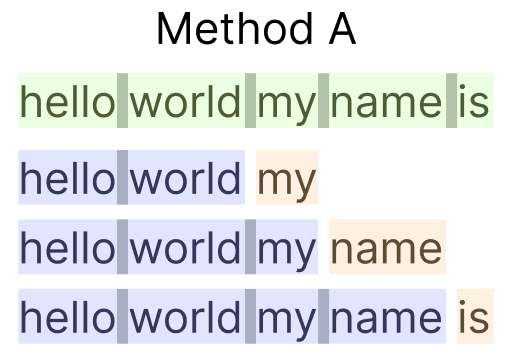

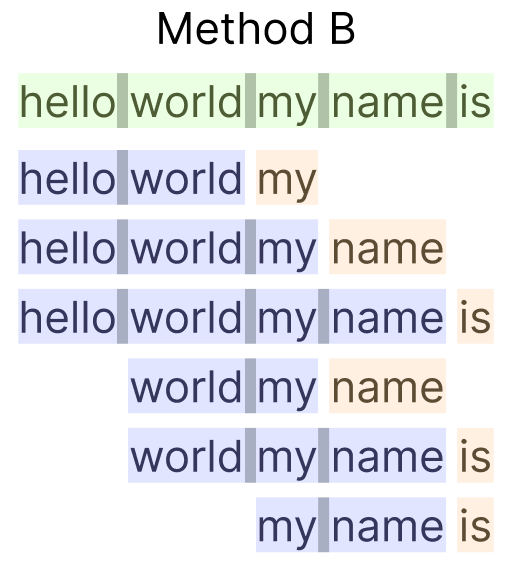

In [110]:
display(Image("images/Method A.png"))
display(Image("images/Method B.png"))

**Legend**
* Green is the original text
* Blue becomes the `X`
* Orange becomes the `y`

Method A is a more direct approach and mirrors the target task, where the predicted word is recursively added to the seed text. <br>
Method B extends this idea by creating the `X` starting from subsequent words in the original text. This creates much more data for the models to work with and I think this could help capture the word-to-word relationships better.

For both method A and B I will test and validate on method A, since that is reflective of the final word prediction task.

In [29]:
# Method A

simple_GRU_A = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_A.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

prepro_methods = {}

# min length 2
X_train, y_train = sentences_to_data(train, 2, False, tokenize=False, verbose=0)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=0)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=0)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

prepro_methods["A"] = fit_model(simple_GRU_A, "", batch_size=64, epochs=50)

# Method B

simple_GRU_B = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU_B.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=0)
# X_test, y_test = sentences_to_data(test, 2, True, tokenize=False, verbose=0)
# X_validation, y_validation = sentences_to_data(validation, 2, True, tokenize=False, verbose=0)

temp = list(zip(X_train, y_train))
random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train = np.array(X_train)
y_train = np.array(y_train)

temp = list(zip(X_validation, y_validation))
random.shuffle(temp)
X_validation, y_validation = zip(*temp)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

temp = list(zip(X_test, y_test))
random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test = np.array(X_test)
y_test = np.array(y_test)

simple_GRU_B.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
prepro_methods["B"] = fit_model(simple_GRU_B, "", batch_size=256, epochs=50)

Epoch 1/50
97/97 [==============================] - 7s 39ms/step - loss: 5.9908 - accuracy: 0.0948 - val_loss: 5.5119 - val_accuracy: 0.0794
Epoch 2/50
97/97 [==============================] - 2s 18ms/step - loss: 5.1033 - accuracy: 0.1364 - val_loss: 5.0789 - val_accuracy: 0.1415
Epoch 3/50
97/97 [==============================] - 1s 15ms/step - loss: 4.5140 - accuracy: 0.2036 - val_loss: 4.6200 - val_accuracy: 0.2488
Epoch 4/50
97/97 [==============================] - 2s 16ms/step - loss: 4.0164 - accuracy: 0.2946 - val_loss: 4.3387 - val_accuracy: 0.3027
Epoch 5/50
97/97 [==============================] - 1s 14ms/step - loss: 3.6626 - accuracy: 0.3460 - val_loss: 4.1603 - val_accuracy: 0.3316
Epoch 6/50
97/97 [==============================] - 1s 14ms/step - loss: 3.3910 - accuracy: 0.3926 - val_loss: 4.0486 - val_accuracy: 0.3450
Epoch 7/50
97/97 [==============================] - 1s 15ms/step - loss: 3.1704 - accuracy: 0.4122 - val_loss: 3.9718 - val_accuracy: 0.3523
Epoch 8/50
97

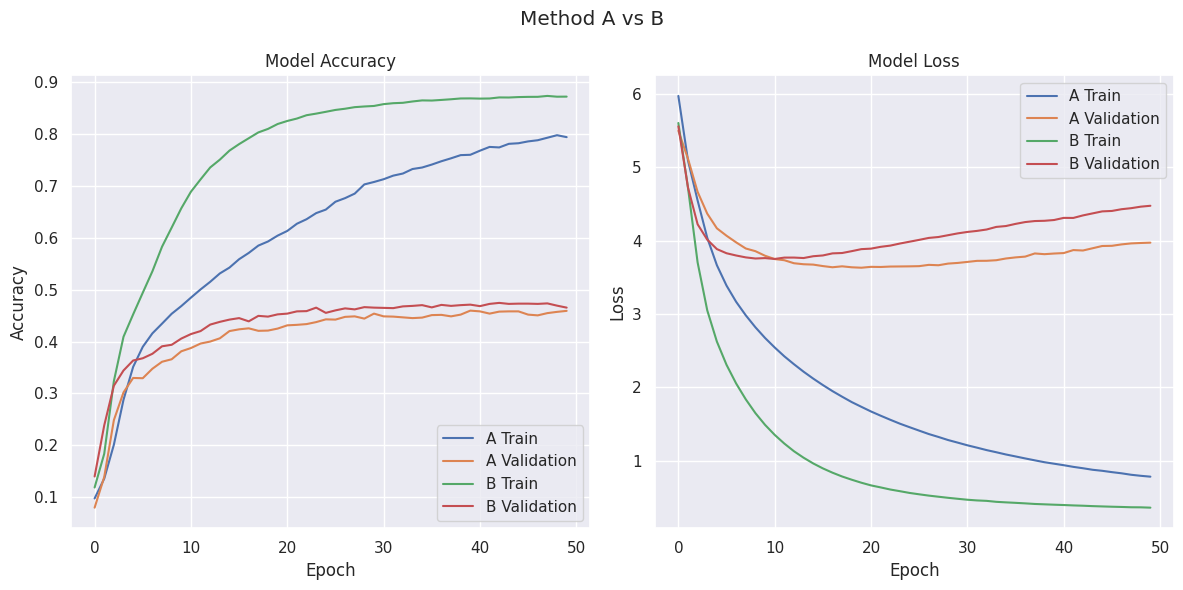

In [90]:
plot_history(prepro_methods, title="Method A vs B")

In [27]:
def eval_different_length_test(model, min_len=2, max_len=12):
    y = []
    for i in range(min_len, max_len+1):
    
        X_test, y_test = sentences_to_data(test, i, False, max_len=i+1, tokenize=False, verbose=0)
        
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        y.append(accuracy)
    return list(range(min_len, max_len+1)), y

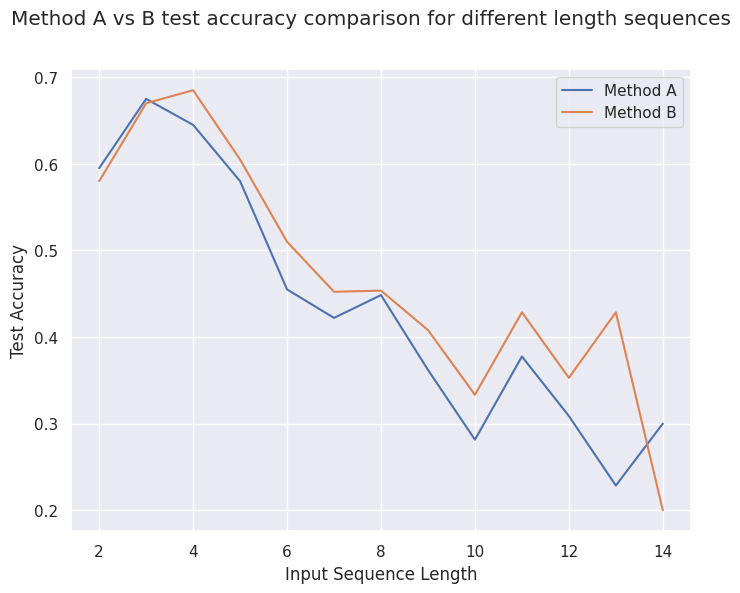

In [30]:
plt.figure(figsize=(8, 6))

x, y = eval_different_length_test(simple_GRU_A, max_len=14)
axA = sns.lineplot(x=x, y=y, label="Method A")

x, y = eval_different_length_test(simple_GRU_B, max_len=14)
axB = sns.lineplot(x=x, y=y, label="Method B")

# plt.legend(["Method A", "Method B"])
plt.legend()
plt.ylabel("Test Accuracy")
plt.xlabel("Input Sequence Length")
plt.suptitle("Method A vs B test accuracy comparison for different length sequences")

plt.show()

In [31]:
def objective_task(model, seed_texts=seed_texts):
    output_text = []
    for seed_text in tqdm(seed_texts):
        output_text.append(predict_next_word(model, seed_text, next_words=10))
    return output_text

In [314]:
predicted_text_A = objective_task(simple_GRU_A)
predicted_text_A

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day is a testament to the world with joy and lightheartedness',
 'radiate some for it is the music of a joyful heart this',
 'believe that breathe life story with compassion and understanding up every day',
 "life's actual purpose is the music that plays in our hearts and minds resentment",
 'dance through each and every to your true self shine for they unveil the brilliance',
 'let your time and energy coastal ecosystems ecosystems ecosystems ecosystems ecosystems ecosystems ecosystems ecosystems ecosystems',
 'every person is a reminder of the soul from bitterness and uplift to',
 "our country Singapore is diverse and breathtaking views singapore's nature is diverse and",
 'planet earth is rich and vibrant and embraces diversity intertwine creating a vibrant',
 'morning and evening would make it transforms your world with joy wherever you go go encounter']

In [315]:
predicted_text_B = objective_task(simple_GRU_B)
predicted_text_B

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day you seek to face the day with strength and wisdom',
 'radiate some for it is the heartbeat of humanity this morning let',
 'believe that unlocks your heart for they resonate with your true self',
 "life's actual purpose is an investment in your future success of life's precious",
 'dance through each and every step we take forward is a victory on the path',
 "let your time and energy a brighter tomorrow's beauty knows no bounds limits bounds",
 'every person is a testament to the beauty of the human spirit and',
 'our country Singapore is its strength for others find their way by it guide',
 'planet earth is rich with the fruits of love and joy that touches',
 "morning and evening would make it holds the promise of a brighter tomorrow's beauty knows"]

* Both methods are comparable in their final results, however method B seems to improve much faster than method A.
* The comparison for test accuracy of sequences of different lengths shows that method B generally performs better.
* Both methods plateau at around 0.47 validation accuracy, while there is an inflection point where validation loss begins to increase for both.

Some sequences of words repeated in the dataset can be followed by various different words, which may be part of the reason why the probability is high for a large number of words.

## Evaluating Grammar

In [32]:
def check_grammar(text):
    return tool.check(text)

def score_grammar(texts):
    grammar_score = 0
    mistakes = []
    for text in texts:
        mistakes.append(check_grammar(text))
        grammar_score += len(mistakes[-1])
    grammar_score /= len(texts)
    return grammar_score, mistakes

In [317]:
print(f"Method A average number of mistakes : {score_grammar(predicted_text_A)[0]}")
print(f"Method B average number of mistakes : {score_grammar(predicted_text_B)[0]}")

Method A average number of mistakes : 1.4
Method B average number of mistakes : 1.0


In [318]:
print(f"Average number of mistakes in the given dataset: {score_grammar(list(df['Quotes']))[0]}")

Average number of mistakes in the given dataset: 0.05


In [319]:
test[:10]

519                        Let your generosity be the ripple that creates waves of kindness.
837                       In the rustle of grass, we find the rhythm of our planet's breath.
208                                         Believe in yourself, and you will find your way.
525                            Let your heart be open to the beauty and wonder of the world.
978    This morning, let your actions be the legacy of love and compassion you leave behind.
583                                Let your authenticity be the bridge that connects hearts.
508                 Let your creativity flow, for it is the source of endless possibilities.
158                       Radiate enthusiasm, and let it be the wildfire that sparks change.
589                                Let your confidence be the wind that propels you forward.
201                                        Believe in yourself, and you will be unstoppable.
Name: Quotes, dtype: object

In [320]:
import pickle

In [321]:
test_seed_texts = []
for sentence in test:
    test_seed_texts.append(" ".join(tokenize_regex(sentence)[:2]))
test_seed_texts[:10]

['Let your',
 'In the',
 'Believe in',
 'Let your',
 'This morning',
 'Let your',
 'Let your',
 'Radiate enthusiasm',
 'Let your',
 'Believe in']

In [322]:
predicted_test_text_A = objective_task(simple_GRU_A, seed_texts=test_seed_texts)
predicted_test_text_A[:10]

  0%|          | 0/200 [00:00<?, ?it/s]

['Let your kindness be the compass that guides you to your heart',
 'In the heart of this lion city compassion lights the way for',
 'Believe in yourself and you will be a beacon of hope for',
 'Let your kindness be the compass that guides you to your heart',
 'This morning let your kindness be the compass that guides you to',
 'Let your kindness be the compass that guides you to your heart',
 'Let your kindness be the compass that guides you to your heart',
 'Radiate enthusiasm and let it be the foundation of your soul filling',
 'Let your kindness be the compass that guides you to your heart',
 'Believe in yourself and you will be a beacon of hope for']

In [324]:
grammar_score, mistakes = score_grammar(predicted_test_text_A)
print(grammar_score)
all_mistakes = []
for mistake in mistakes:
    all_mistakes += mistake

0.07


In [325]:
[x.message for x in all_mistakes]

['Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible typo: you repeated a word',
 'Possible typo: you repeated a word',
 'Possible typo: you repeated a word']

In [326]:
predicted_test_text_B = objective_task(simple_GRU_B, seed_texts=test_seed_texts)
predicted_test_text_B[:10]

  0%|          | 0/200 [00:00<?, ?it/s]

['Let your heart be the conductor that propels you forward is a',
 'In the heart of this lion city dreams are nurtured and realized',
 'Believe in yourself and you will be a beacon of light for',
 'Let your heart be the conductor that propels you forward is a',
 'This morning let your kindness be the spark that ignites positivity and',
 'Let your heart be the conductor that propels you forward is a',
 'Let your heart be the conductor that propels you forward is a',
 'Radiate enthusiasm and let it be the armor that shields your heart',
 'Let your heart be the conductor that propels you forward is a',
 'Believe in yourself and you will be a beacon of light for']

In [327]:
grammar_score, mistakes = score_grammar(predicted_test_text_B)
print(grammar_score)
all_mistakes = []
for mistake in mistakes:
    all_mistakes += mistake

0.125


In [328]:
[x.message for x in all_mistakes]

['Possible spelling mistake found.',
 'Possible typo: you repeated a word',
 'This phrase is duplicated. You should probably use “the marvel” only once.',
 'This phrase is duplicated. You should probably use “a testament” only once.',
 'Possible typo: you repeated a word',
 'Possible spelling mistake found.',
 'This phrase is duplicated. You should probably use “a symphony” only once.',
 'Possible spelling mistake found.',
 'This phrase is duplicated. You should probably use “a testament” only once.',
 'This phrase is duplicated. You should probably use “a testament” only once.',
 'This phrase is duplicated. You should probably use “a testament” only once.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',
 'Possible spelling mistake found.',


Method B may be more prone to repeating words or phrases.

## Evaluation using BERT Score

In [338]:
P, R, F1 = score(predicted_test_text_A, list(test), lang="en", verbose=True)

# Print or use the computed scores
print("Precision:", P.mean().item())
print("Recall:", R.mean().item())
print("F1 Score:", F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.34 seconds, 579.73 sentences/sec
Precision: 0.899127721786499
Recall: 0.9092965126037598
F1 Score: 0.9041364192962646


In [339]:
P, R, F1 = score(predicted_test_text_B, list(test), lang="en", verbose=True)

# Print or use the computed scores
print("Precision:", P.mean().item())
print("Recall:", R.mean().item())
print("F1 Score:", F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.29 seconds, 699.60 sentences/sec
Precision: 0.8908454775810242
Recall: 0.9045246243476868
F1 Score: 0.8975802659988403


In [51]:
def calculate_scoring_metrics(model):
    test_seed_texts = []
    for sentence in test:
        test_seed_texts.append(" ".join(tokenize_regex(sentence)[:2]))
    
    scores = {}
    predicted_test_texts = objective_task(model, seed_texts=test_seed_texts)
    P, R, F1 = score(predicted_test_texts, list(test), lang="en", verbose=True)

    scores["Precision"] = P.mean().item()
    scores["Recall"] = R.mean().item()
    scores["F1"] = F1.mean().item()

    grammar_score, mistakes = score_grammar(predicted_test_texts)
    all_mistakes = []
    for mistake in mistakes:
        all_mistakes += mistake
    
    scores["mean_mistakes"] = grammar_score
    # scores["mistakes"] = all_mistakes
    return scores

I will use Method B when evaluating the different model architectures since it trains faster.

In [34]:
X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=0)
X_test, y_test = sentences_to_data(test, 2, False, tokenize=False, verbose=0)
X_validation, y_validation = sentences_to_data(validation, 2, False, tokenize=False, verbose=0)

## SimpleRNN (Recurrent Neural Network) vs GRU (Gated Recurrent Unit) vs LSTM (Long Short-Term Memory)

In [37]:
all_RNN_scores = {}
basic_RNNs = {}

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=0,
    patience=1,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

In [38]:
simple_RNN = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    SimpleRNN(64),
    Dense(total_words, activation='softmax')
])
simple_RNN.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

basic_RNNs["SimpleRNN"] = fit_model(simple_RNN, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 13s 78ms/step - loss: 5.4612 - accuracy: 0.1129 - val_loss: 5.0306 - val_accuracy: 0.1578
Epoch 2/50
150/150 [==============================] - 10s 65ms/step - loss: 4.0970 - accuracy: 0.2561 - val_loss: 4.2585 - val_accuracy: 0.3061
Epoch 3/50
150/150 [==============================] - 9s 59ms/step - loss: 3.2102 - accuracy: 0.3854 - val_loss: 3.9207 - val_accuracy: 0.3436
Epoch 4/50
150/150 [==============================] - 9s 58ms/step - loss: 2.6032 - accuracy: 0.4791 - val_loss: 3.7588 - val_accuracy: 0.3782
Epoch 5/50
150/150 [==============================] - 9s 61ms/step - loss: 2.1606 - accuracy: 0.5492 - val_loss: 3.6792 - val_accuracy: 0.3985
Epoch 6/50
150/150 [==============================] - 9s 61ms/step - loss: 1.8249 - accuracy: 0.6118 - val_loss: 3.6299 - val_accuracy: 0.4057
Epoch 7/50
150/150 [==============================] - 9s 59ms/step - loss: 1.5606 - accuracy: 0.6663 - val_loss: 3.6094 - val_accuracy: 0.41

In [39]:
simple_RNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 40, 768)           912384    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                53312     
                                                                 
 dense_3 (Dense)             (None, 1188)              77220     
                                                                 
Total params: 1042916 (3.98 MB)
Trainable params: 1042916 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
display(objective_task(simple_RNN))
all_RNN_scores["simpleRNN"] = calculate_scoring_metrics(simple_RNN)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day full of possibilities for they paint the world with compassion',
 'radiate some for it sets your heart free from burdens chains of',
 'believe that deserves compassion and love and kindness that resonates with the',
 "life's actual purpose is a beacon that lights your way by it every day",
 'dance through each and every sunrise this morning offers the promise of a fresh start',
 "let your time and energy is alive treasure trove of life's tenacity is a",
 'every person is more beautiful when we move with grace and gratitude and',
 "our country Singapore is diverse and breathtaking views singapore's nature is diverse and",
 'planet earth is a tribute to the boundless power of the heart to',
 "morning and evening would make it nourishes the seeds of your future success our planet's"]

  0%|          | 0/200 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.32 seconds, 626.91 sentences/sec


In [43]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(64),
    Dense(total_words, activation='softmax')
])
simple_GRU.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

basic_RNNs["GRU"] = fit_model(simple_GRU, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 6s 30ms/step - loss: 5.6185 - accuracy: 0.1096 - val_loss: 5.5093 - val_accuracy: 0.1405
Epoch 2/50
150/150 [==============================] - 3s 18ms/step - loss: 4.6293 - accuracy: 0.1944 - val_loss: 4.6277 - val_accuracy: 0.2541
Epoch 3/50
150/150 [==============================] - 2s 13ms/step - loss: 3.6272 - accuracy: 0.3373 - val_loss: 4.1973 - val_accuracy: 0.3306
Epoch 4/50
150/150 [==============================] - 2s 13ms/step - loss: 3.0028 - accuracy: 0.4166 - val_loss: 4.0093 - val_accuracy: 0.3532
Epoch 5/50
150/150 [==============================] - 2s 14ms/step - loss: 2.5790 - accuracy: 0.4600 - val_loss: 3.9051 - val_accuracy: 0.3657
Epoch 6/50
150/150 [==============================] - 2s 14ms/step - loss: 2.2617 - accuracy: 0.5014 - val_loss: 3.8334 - val_accuracy: 0.3739
Epoch 7/50
150/150 [==============================] - 2s 12ms/step - loss: 2.0043 - accuracy: 0.5475 - val_loss: 3.7862 - val_accuracy: 0.3884

In [44]:
simple_GRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 40, 768)           912384    
                                                                 
 gru_2 (GRU)                 (None, 64)                160128    
                                                                 
 dense_4 (Dense)             (None, 1188)              77220     
                                                                 
Total params: 1149732 (4.39 MB)
Trainable params: 1149732 (4.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
display(objective_task(simple_GRU))
all_RNN_scores["GRU"] = calculate_scoring_metrics(simple_GRU)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day leaving threads of inspiration and heart this morning find the',
 'radiate some for it carries the echoes of a life well lived',
 'believe that strength and resilience a reminder that you are capable of',
 "life's actual purpose is alive of nature be your guiding light for others find",
 'dance through each and every breath let gratitude fill your lungs and heart reminding you',
 'let your time and energy is palpable an investment in your future success the potential',
 'every person is a beacon of light a guiding star that illuminates the',
 'our country Singapore is a fresh start and new beginnings reminding us of the',
 'planet earth is written with the pen of our experiences and choices we',
 'morning and evening would make it is the heartbeat of humanity potential is limitless and potential']

  0%|          | 0/200 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.29 seconds, 689.59 sentences/sec


In [46]:
simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    LSTM(64),
    Dense(total_words, activation='softmax')
])
simple_LSTM.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


basic_RNNs["LSTM"] = fit_model(simple_LSTM, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 7s 37ms/step - loss: 5.6654 - accuracy: 0.0866 - val_loss: 5.6340 - val_accuracy: 0.0885
Epoch 2/50
150/150 [==============================] - 3s 19ms/step - loss: 5.0507 - accuracy: 0.0987 - val_loss: 5.2392 - val_accuracy: 0.0972
Epoch 3/50
150/150 [==============================] - 2s 12ms/step - loss: 4.5547 - accuracy: 0.1890 - val_loss: 4.7975 - val_accuracy: 0.2474
Epoch 4/50
150/150 [==============================] - 2s 12ms/step - loss: 3.9902 - accuracy: 0.2829 - val_loss: 4.4545 - val_accuracy: 0.2916
Epoch 5/50
150/150 [==============================] - 2s 12ms/step - loss: 3.5522 - accuracy: 0.3480 - val_loss: 4.2687 - val_accuracy: 0.3162
Epoch 6/50
150/150 [==============================] - 2s 12ms/step - loss: 3.2072 - accuracy: 0.3863 - val_loss: 4.1389 - val_accuracy: 0.3268
Epoch 7/50
150/150 [==============================] - 2s 12ms/step - loss: 2.9159 - accuracy: 0.4163 - val_loss: 4.0409 - val_accuracy: 0.3378

In [47]:
simple_LSTM.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 40, 768)           912384    
                                                                 
 lstm_1 (LSTM)               (None, 64)                213248    
                                                                 
 dense_5 (Dense)             (None, 1188)              77220     
                                                                 
Total params: 1202852 (4.59 MB)
Trainable params: 1202852 (4.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
display(objective_task(simple_LSTM))
all_RNN_scores["LSTM"] = calculate_scoring_metrics(simple_LSTM)

  0%|          | 0/10 [00:00<?, ?it/s]

['embrace each day leaving a trail of smiles and warmth and appreciation find',
 'radiate some for it is the heartbeat of humanity every moment of',
 'believe that propels you forward is a beacon of light and a',
 "life's actual purpose is a step towards a contented heart and the power of",
 'dance through each and every day is a gift a legacy of warmth and affection',
 'let your time and energy it is the tapestry of humanity every corner of your',
 'every person is the tapestry of life leaving threads of inspiration and emotions',
 "our country Singapore is's beauty is boundless world with boundless possibilities it brings",
 "planet earth is's vitality is the pursuit of our passions and dreams",
 'morning and evening would make it is the compass of your soul on the universe a']

  0%|          | 0/200 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.31 seconds, 654.95 sentences/sec


In [55]:
all_RNN_scores

{'simpleRNN': {'Precision': 0.8914614915847778,
  'Recall': 0.9034144878387451,
  'F1': 0.8973492383956909,
  'mean_mistakes': 0.155},
 'GRU': {'Precision': 0.8888418078422546,
  'Recall': 0.9041783809661865,
  'F1': 0.8963746428489685,
  'mean_mistakes': 0.13},
 'LSTM': {'Precision': 0.889177143573761,
  'Recall': 0.9026126265525818,
  'F1': 0.8958010077476501,
  'mean_mistakes': 0.145}}

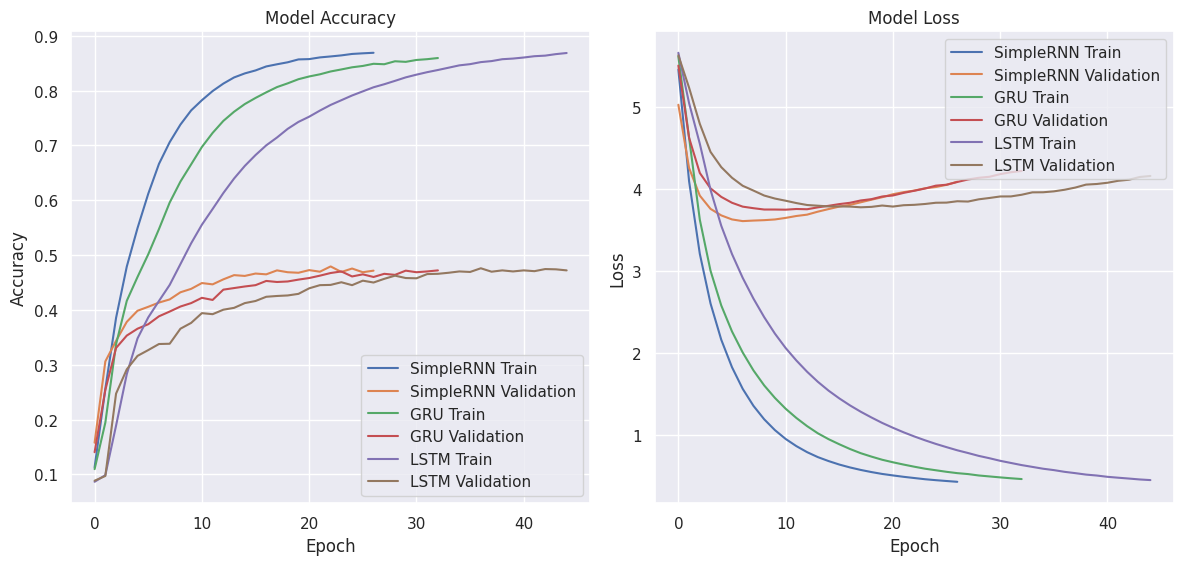

In [49]:
plot_history(basic_RNNs, "")

* SimpleRNN, LSTM, and GRU can all achieve roughly the same accuracy.
* All of the models start overfitting quickly.
* GRU is the fastest to train followed by LSTM then SimpleRNN in terms of time
* All of the models have an increasing loss over time.
* Both LSTM and GRU could work for this application so I may explore both.

## Model Improvement
* Increasing model complexity (Number of units, number of layers)
* Bidirectional
* Attention Mechanism
* n-gram Text Vectorization

In [56]:
more_RNNs = {}

simple_GRU_128 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(128),
    Dense(total_words, activation='softmax')
])
simple_GRU_128.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_RNNs["GRU_128"] = fit_model(simple_GRU_128, "", batch_size=256, epochs=50, callbacks=[early_stopping])
all_RNN_scores["GRU_128"] = calculate_scoring_metrics(simple_GRU_128)

simple_GRU_128_2 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(128, return_sequences=True),
    GRU(128),
    Dense(total_words, activation='softmax')
])
simple_GRU_128_2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=1,
    min_delta=0.002,
    mode="max",
    restore_best_weights=True
)

more_RNNs["GRU_128_2"] = fit_model(simple_GRU_128_2, "", batch_size=256, epochs=50, callbacks=[early_stopping])
all_RNN_scores["GRU_128_2"] = calculate_scoring_metrics(simple_GRU_128_2)

Epoch 1/50
150/150 [==============================] - 6s 34ms/step - loss: 5.3606 - accuracy: 0.1366 - val_loss: 5.0472 - val_accuracy: 0.2199
Epoch 2/50
150/150 [==============================] - 2s 17ms/step - loss: 3.7686 - accuracy: 0.3179 - val_loss: 4.1847 - val_accuracy: 0.3397
Epoch 3/50
150/150 [==============================] - 2s 13ms/step - loss: 2.7369 - accuracy: 0.4418 - val_loss: 3.8890 - val_accuracy: 0.3686
Epoch 4/50
150/150 [==============================] - 2s 12ms/step - loss: 2.0705 - accuracy: 0.5478 - val_loss: 3.7712 - val_accuracy: 0.3956
Epoch 5/50
150/150 [==============================] - 2s 12ms/step - loss: 1.6026 - accuracy: 0.6411 - val_loss: 3.7065 - val_accuracy: 0.4090
Epoch 6/50
150/150 [==============================] - 2s 13ms/step - loss: 1.2651 - accuracy: 0.7105 - val_loss: 3.6703 - val_accuracy: 0.4355
Epoch 7/50
150/150 [==============================] - 2s 12ms/step - loss: 1.0248 - accuracy: 0.7598 - val_loss: 3.6740 - val_accuracy: 0.4543

  0%|          | 0/200 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.32 seconds, 616.32 sentences/sec
Epoch 1/50
150/150 [==============================] - 9s 45ms/step - loss: 5.5289 - accuracy: 0.0765 - val_loss: 5.7726 - val_accuracy: 0.0751
Epoch 2/50
150/150 [==============================] - 3s 21ms/step - loss: 5.2602 - accuracy: 0.0961 - val_loss: 5.5850 - val_accuracy: 0.1477
Epoch 3/50
150/150 [==============================] - 3s 17ms/step - loss: 4.5909 - accuracy: 0.2078 - val_loss: 4.8662 - val_accuracy: 0.2300
Epoch 4/50
150/150 [==============================] - 3s 17ms/step - loss: 3.5273 - accuracy: 0.3488 - val_loss: 4.2707 - val_accuracy: 0.3258
Epoch 5/50
150/150 [==============================] - 3s 17ms/step - loss: 2.5994 - accuracy: 0.4881 - val_loss: 4.0379 - val_accuracy: 0.3903
Epoch 6/50
150/150 [==============================] - 3s 19ms/step - loss: 1.9514 - accuracy: 0.6020 - val_loss: 3.8995 - val_accuracy: 0.4124
Epoch 7/50
150/150 [==============================] - 3s 18ms/step - loss: 1.4951 - accuracy: 0.685

  0%|          | 0/200 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.32 seconds, 622.84 sentences/sec


In [58]:
all_RNN_scores

{'simpleRNN': {'Precision': 0.8914614915847778,
  'Recall': 0.9034144878387451,
  'F1': 0.8973492383956909,
  'mean_mistakes': 0.155},
 'GRU': {'Precision': 0.8888418078422546,
  'Recall': 0.9041783809661865,
  'F1': 0.8963746428489685,
  'mean_mistakes': 0.13},
 'LSTM': {'Precision': 0.889177143573761,
  'Recall': 0.9026126265525818,
  'F1': 0.8958010077476501,
  'mean_mistakes': 0.145},
 'GRU_128': {'Precision': 0.8907427787780762,
  'Recall': 0.902946949005127,
  'F1': 0.8967529535293579,
  'mean_mistakes': 0.215},
 'GRU_128_2': {'Precision': 0.889689564704895,
  'Recall': 0.9020628333091736,
  'F1': 0.8957895636558533,
  'mean_mistakes': 0.14}}

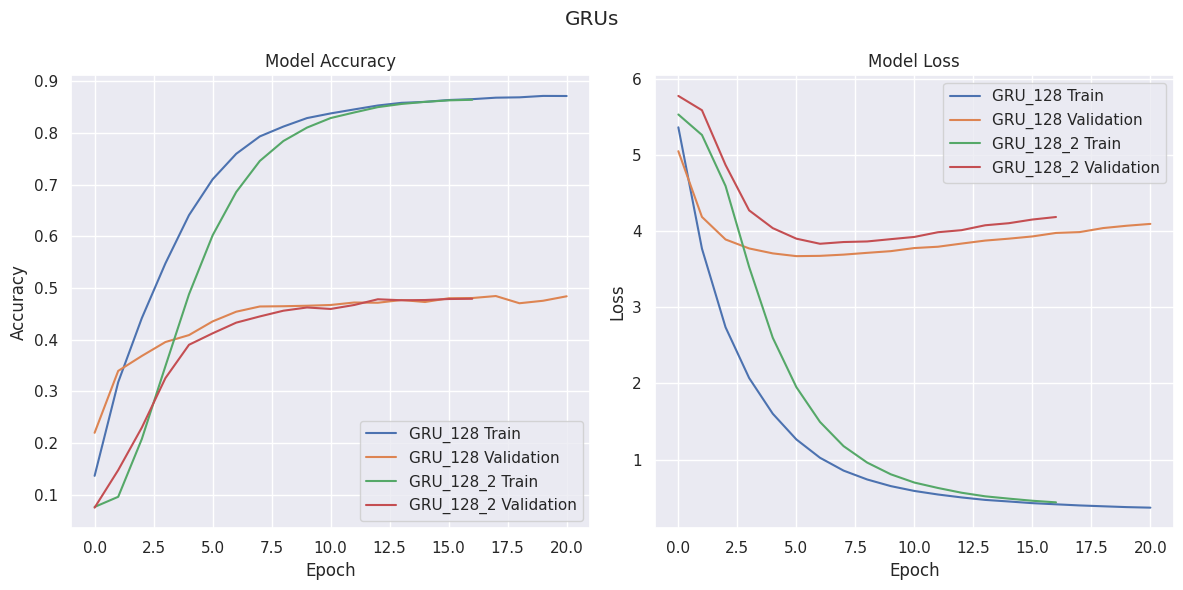

In [57]:
plot_history(more_RNNs, "GRUs")

No benefit to using 2 layers since the data is already not very complex.

In [ ]:
more_RNNs = {"GRU_128": more_RNNs["GRU_128"]}

simple_GRU_256 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(256),
    Dense(total_words, activation='softmax')
])
simple_GRU_256.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_RNNs["GRU_256"] = fit_model(simple_GRU_256, "", batch_size=256, epochs=50, callbacks=[early_stopping])
all_RNN_scores["GRU_256"] = calculate_scoring_metrics(simple_GRU_256)

simple_GRU_512 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(512),
    Dense(total_words, activation='softmax')
])
simple_GRU_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_RNNs["GRU_512"] = fit_model(simple_GRU_512, "", batch_size=256, epochs=50, callbacks=[early_stopping])
all_RNN_scores["GRU_512"] = calculate_scoring_metrics(simple_GRU_512)

simple_GRU_1024 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(1024),
    Dense(total_words, activation='softmax')
])
simple_GRU_1024.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

more_RNNs["GRU_1024"] = fit_model(simple_GRU_1024, "", batch_size=256, epochs=50, callbacks=[early_stopping])
all_RNN_scores["GRU_1024"] = calculate_scoring_metrics(simple_GRU_1024)

Epoch 1/50
150/150 [==============================] - 7s 32ms/step - loss: 4.8255 - accuracy: 0.2068 - val_loss: 4.3132 - val_accuracy: 0.2964
Epoch 2/50
150/150 [==============================] - 3s 18ms/step - loss: 2.6160 - accuracy: 0.4576 - val_loss: 3.7245 - val_accuracy: 0.3956
Epoch 3/50
150/150 [==============================] - 2s 14ms/step - loss: 1.5382 - accuracy: 0.6525 - val_loss: 3.5781 - val_accuracy: 0.4490
Epoch 4/50
150/150 [==============================] - 2s 13ms/step - loss: 0.9894 - accuracy: 0.7639 - val_loss: 3.5815 - val_accuracy: 0.4577
Epoch 5/50
150/150 [==============================] - 2s 13ms/step - loss: 0.7180 - accuracy: 0.8157 - val_loss: 3.6147 - val_accuracy: 0.4740
Epoch 6/50
150/150 [==============================] - 2s 13ms/step - loss: 0.5794 - accuracy: 0.8408 - val_loss: 3.6426 - val_accuracy: 0.4870
Epoch 7/50
150/150 [==============================] - 2s 12ms/step - loss: 0.4995 - accuracy: 0.8542 - val_loss: 3.7099 - val_accuracy: 0.4986

  0%|          | 0/200 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.29 seconds, 686.67 sentences/sec
Epoch 1/50
150/150 [==============================] - 8s 40ms/step - loss: 4.2215 - accuracy: 0.2708 - val_loss: 3.9236 - val_accuracy: 0.3571
Epoch 2/50
150/150 [==============================] - 3s 19ms/step - loss: 1.6706 - accuracy: 0.6289 - val_loss: 3.6844 - val_accuracy: 0.4437
Epoch 3/50
150/150 [==============================] - 2s 15ms/step - loss: 0.8505 - accuracy: 0.7858 - val_loss: 3.7664 - val_accuracy: 0.4711
Epoch 4/50
150/150 [==============================] - 2s 14ms/step - loss: 0.5963 - accuracy: 0.8376 - val_loss: 3.8395 - val_accuracy: 0.4880
Epoch 5/50
150/150 [==============================] - 2s 13ms/step - loss: 0.4959 - accuracy: 0.8543 - val_loss: 3.9284 - val_accuracy: 0.4899
Epoch 6/50
150/150 [==============================] - 2s 14ms/step - loss: 0.4500 - accuracy: 0.8623 - val_loss: 3.9446 - val_accuracy: 0.4894
Epoch 7/50
150/150 [==============================] - 2s 14ms/step - loss: 0.4200 - accuracy: 0.865

  0%|          | 0/200 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 0.38 seconds, 527.07 sentences/sec
Epoch 1/50
150/150 [==============================] - 8s 37ms/step - loss: 3.7980 - accuracy: 0.3234 - val_loss: 3.7891 - val_accuracy: 0.4004
Epoch 2/50
150/150 [==============================] - 3s 20ms/step - loss: 1.2222 - accuracy: 0.7067 - val_loss: 3.8109 - val_accuracy: 0.4629
Epoch 3/50
150/150 [==============================] - 2s 16ms/step - loss: 0.6809 - accuracy: 0.8198 - val_loss: 3.9693 - val_accuracy: 0.4769
Epoch 4/50
150/150 [==============================] - 2s 16ms/step - loss: 0.5333 - accuracy: 0.8515 - val_loss: 4.0027 - val_accuracy: 0.4933
Epoch 5/50
150/150 [==============================] - 2s 15ms/step - loss: 0.4784 - accuracy: 0.8596 - val_loss: 4.0926 - val_accuracy: 0.4889
Epoch 6/50
150/150 [==============================] - 2s 16ms/step - loss: 0.4570 - accuracy: 0.8644 - val_loss: 4.0564 - val_accuracy: 0.4875
Epoch 7/50
150/150 [==============================] - 2s 15ms/step - loss: 0.4314 - accuracy: 0.866

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
all_RNN_scores

In [ ]:
plot_history(more_RNNs, "GRUs")

Both 256 and 512 are able to capture the information well.

In [ ]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=40,
    ngrams=4
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

In [141]:
ngram_RNNs = {"1-gram": more_RNNs["GRU_512"]}

early_stopping = EarlyStopping(
    monitor="accuracy",
    start_from_epoch=0,
    patience=2,
    min_delta=0,
    mode="max",
    restore_best_weights=True
)

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=2
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_GRU_512 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(512),
    Dense(total_words, activation='softmax')
])
simple_GRU_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["2-gram"] = fit_model(simple_GRU_512, "", batch_size=256, epochs=50, callbacks=[early_stopping])

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=3
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_GRU_512 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(512),
    Dense(total_words, activation='softmax')
])
simple_GRU_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["3-gram"] = fit_model(simple_GRU_512, "", batch_size=256, epochs=50, callbacks=[early_stopping])

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=4
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

simple_GRU_512 = Sequential([
    vectorize_layer,
    Embedding(total_words, 768, mask_zero=True),
    GRU(512),
    Dense(total_words, activation='softmax')
])
simple_GRU_512.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

ngram_RNNs["4-gram"] = fit_model(simple_GRU_512, "", batch_size=256, epochs=50, callbacks=[early_stopping])

Epoch 1/50
150/150 [==============================] - 12s 59ms/step - loss: 4.5579 - accuracy: 0.2361 - val_loss: 4.0987 - val_accuracy: 0.3720
Epoch 2/50
150/150 [==============================] - 5s 35ms/step - loss: 2.3421 - accuracy: 0.5002 - val_loss: 3.9006 - val_accuracy: 0.4379
Epoch 3/50
150/150 [==============================] - 4s 25ms/step - loss: 1.5133 - accuracy: 0.6254 - val_loss: 4.0659 - val_accuracy: 0.4678
Epoch 4/50
150/150 [==============================] - 3s 21ms/step - loss: 1.1180 - accuracy: 0.7012 - val_loss: 4.1636 - val_accuracy: 0.4644
Epoch 5/50
150/150 [==============================] - 3s 20ms/step - loss: 0.9070 - accuracy: 0.7433 - val_loss: 4.2981 - val_accuracy: 0.4692
Epoch 6/50
150/150 [==============================] - 3s 21ms/step - loss: 0.7871 - accuracy: 0.7700 - val_loss: 4.3810 - val_accuracy: 0.4740
Epoch 7/50
150/150 [==============================] - 3s 20ms/step - loss: 0.7061 - accuracy: 0.7879 - val_loss: 4.4610 - val_accuracy: 0.483

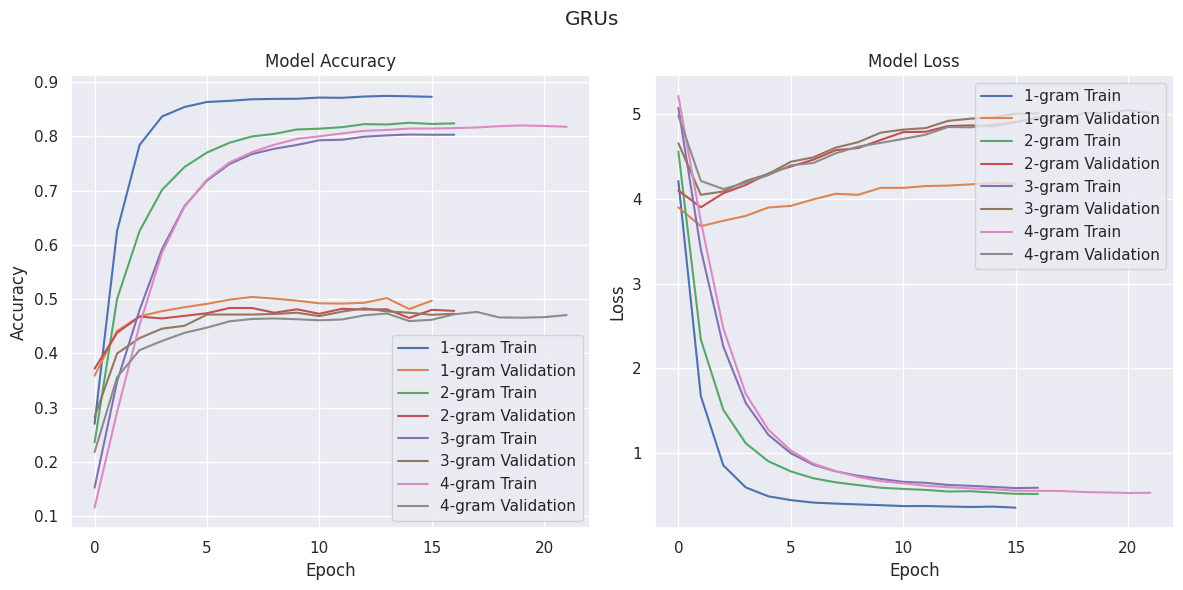

In [142]:
plot_history(ngram_RNNs, "GRUs")

In [162]:
for seed_text in ["", "", ""]:
    predicted_text = predict_next_word(simple_GRU_A, seed_text, next_words=10)
    print(predicted_text)

          moments of joy affection affection joy wherever you go in


In [160]:
vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200,
    ngrams=2
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

vectorize_layer("embrace each day can hearts")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([  25,  182,  134,  245,  121,    1, 1376,    1,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

* Since the dataset is small, there are many n-grams that will not appear in the dataset. Thus they will be set to `1` which skews the results. 
* The result of the n-gram encoding also performs much worse than 1-gram. Thus I will not use n-gram text vectorization.

In [ ]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 1000),
    # Flatten(),
    GRU(200, return_sequences=True),
    GRU(200),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_GRU, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

In [316]:
simple_stacked = Sequential([
    vectorize_layer,
    Embedding(total_words, 1000),
    # Flatten(),
    RNN(StackedRNNCells([LSTMCell(32) for _ in range(2)])),
    # Dense(2000, activation="relu"),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_stacked.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_stacked, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=128, epochs=20)

Epoch 1/20
286/286 [==============================] - 84s 290ms/step - loss: 5.5659 - accuracy: 0.0687 - val_loss: 5.6089 - val_accuracy: 0.0885
Epoch 2/20
286/286 [==============================] - 78s 273ms/step - loss: 5.3031 - accuracy: 0.0726 - val_loss: 5.6810 - val_accuracy: 0.0885
Epoch 3/20
286/286 [==============================] - 77s 269ms/step - loss: 5.3010 - accuracy: 0.0743 - val_loss: 5.7247 - val_accuracy: 0.0628
Epoch 4/20
286/286 [==============================] - 77s 270ms/step - loss: 5.2998 - accuracy: 0.0731 - val_loss: 5.7522 - val_accuracy: 0.0628
Epoch 5/20
286/286 [==============================] - 78s 271ms/step - loss: 5.2989 - accuracy: 0.0727 - val_loss: 5.7772 - val_accuracy: 0.0628
Epoch 6/20
286/286 [==============================] - 79s 276ms/step - loss: 5.2979 - accuracy: 0.0758 - val_loss: 5.7843 - val_accuracy: 0.0885
Epoch 7/20
286/286 [==============================] - 80s 279ms/step - loss: 5.2980 - accuracy: 0.0732 - val_loss: 5.8095 - val_ac

KeyboardInterrupt: 

In [198]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200
)

vectorize_layer.adapt([" ".join(x) for x in tokenized_quotes])

simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 100),
    # Flatten(),
    LSTM(200, return_sequences=True),
    LSTM(200),
    Dense(total_words, activation='softmax')
])


simple_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_LSTM, "training_checkpoints/simple_LSTM_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

Epoch 1/20
 49/241 [=====>........................] - ETA: 57s - loss: 5.6612 - accuracy: 0.0728

KeyboardInterrupt: 

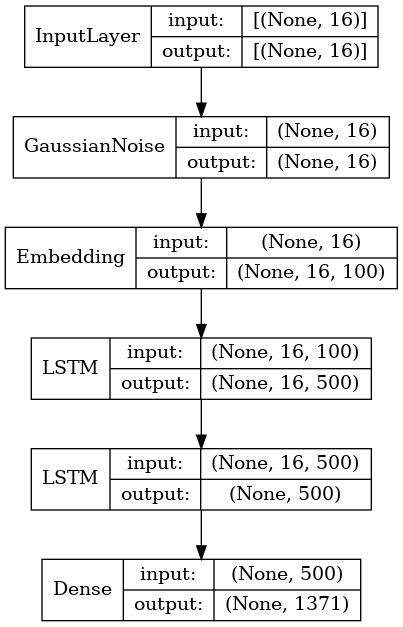

In [117]:
plot_model(simple_RNN, to_file='images/models/simple_LSTM.png', show_shapes=True, show_layer_names=False)

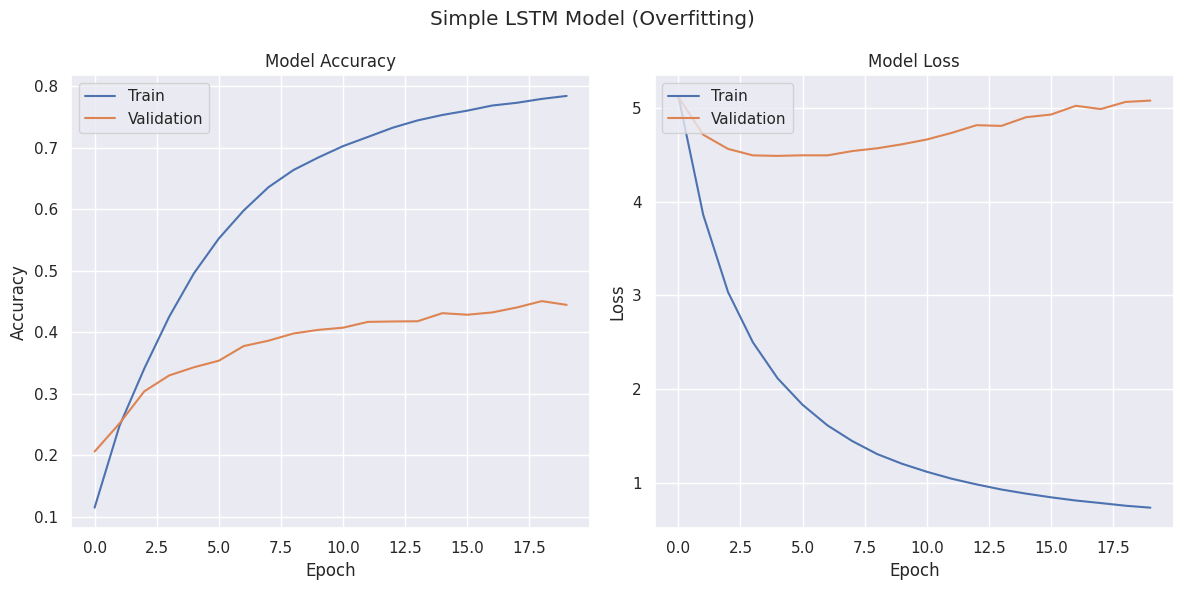

In [104]:
plot_history(history, "Simple LSTM Model (Overfitting)", "images/Simple LSTM Model (Overfitting).png")

* The model is unable to generalise and severely overfits on the training set.

In [45]:
# Attention is all you need

inputs = tf.keras.layers.Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=total_words, output_dim=2000)(inputs)
lstm_layer = GRU(200, return_sequences=True)(embedding_layer)

attention = Attention(use_scale=True)([lstm_layer, lstm_layer])
context_vector = tf.reduce_sum(attention * lstm_layer, axis=1)

output = Dense(total_words, activation='softmax')(context_vector)

attention_model = Model(inputs=inputs, outputs=output)

attention_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(attention_model, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 5.6172 - accuracy: 0.0888
Epoch 1: val_loss improved from inf to 5.49605, saving model to training_checkpoints/simple_RNN_weights.01-0.09.hdf5
153/153 [==============================] - 4s 23ms/step - loss: 5.6172 - accuracy: 0.0888 - val_loss: 5.4960 - val_accuracy: 0.0930
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 5.0289 - accuracy: 0.1218
Epoch 2: val_loss improved from 5.49605 to 5.24764, saving model to training_checkpoints/simple_RNN_weights.02-0.14.hdf5
153/153 [==============================] - 2s 12ms/step - loss: 5.0289 - accuracy: 0.1218 - val_loss: 5.2476 - val_accuracy: 0.1417
Epoch 3/50
153/153 [==============================] - ETA: 0s - loss: 4.5129 - accuracy: 0.1549
Epoch 3: val_loss improved from 5.24764 to 5.01739, saving model to training_checkpoints/simple_RNN_weights.03-0.18.hdf5
153/153 [==============================] - 2s 11ms/step - loss: 4.5129 - accuracy: 0.1549

KeyboardInterrupt: 

In [ ]:
attention_model.summary()

In [276]:
# Build the model
simple_RNN3 = Sequential([
    # GaussianNoise(0.5),
    Embedding(total_words, 100, input_length=max_sequence_length),
    Bidirectional(LSTM(50, return_sequences=True)),
    # LSTM(50, return_sequences=True),
    
    Attention(),
    Dropout(0.3),
    Dense(1000),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
])
simple_RNN3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(simple_RNN3, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

ValueError: Exception encountered when calling layer "attention_3" (type Attention).

Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: Tensor("Placeholder:0", shape=(None, 35, 50), dtype=float32).

Call arguments received by layer "attention_3" (type Attention):
  • inputs=tf.Tensor(shape=(None, 35, 50), dtype=float32)
  • mask=None
  • training=None
  • return_attention_scores=False
  • use_causal_mask=False

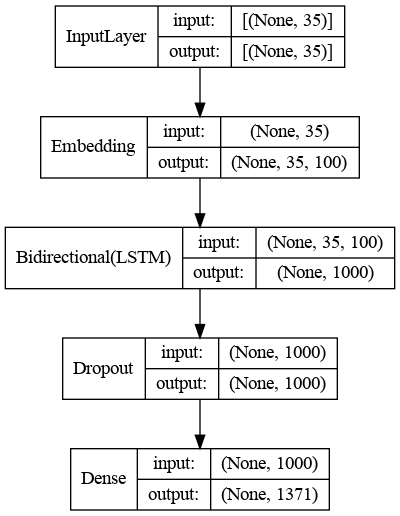

In [260]:
plot_model(simple_RNN3, show_shapes=True, show_layer_names=False)

In [124]:
# Build the model
simple_RNN2 = Sequential([
    GaussianNoise(0.5),
    Embedding(total_words, 100, input_length=max_sequence_length),
    LSTM(100),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
])
simple_RNN2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(simple_RNN2, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=20)

Epoch 1/20
389/389 [==============================] - ETA: 0s - loss: 5.3696 - accuracy: 0.0935
Epoch 1: val_loss improved from inf to 5.39246, saving model to training_checkpoints/simple_RNN_weights.01-0.12.hdf5
389/389 [==============================] - 18s 44ms/step - loss: 5.3696 - accuracy: 0.0935 - val_loss: 5.3925 - val_accuracy: 0.1245
Epoch 2/20
388/389 [============================>.] - ETA: 0s - loss: 4.6576 - accuracy: 0.1743
Epoch 2: val_loss improved from 5.39246 to 4.96396, saving model to training_checkpoints/simple_RNN_weights.02-0.21.hdf5
389/389 [==============================] - 15s 38ms/step - loss: 4.6567 - accuracy: 0.1743 - val_loss: 4.9640 - val_accuracy: 0.2063
Epoch 3/20
388/389 [============================>.] - ETA: 0s - loss: 4.1654 - accuracy: 0.2235
Epoch 3: val_loss improved from 4.96396 to 4.73630, saving model to training_checkpoints/simple_RNN_weights.03-0.25.hdf5
389/389 [==============================] - 13s 35ms/step - loss: 4.1646 - accuracy: 0.2

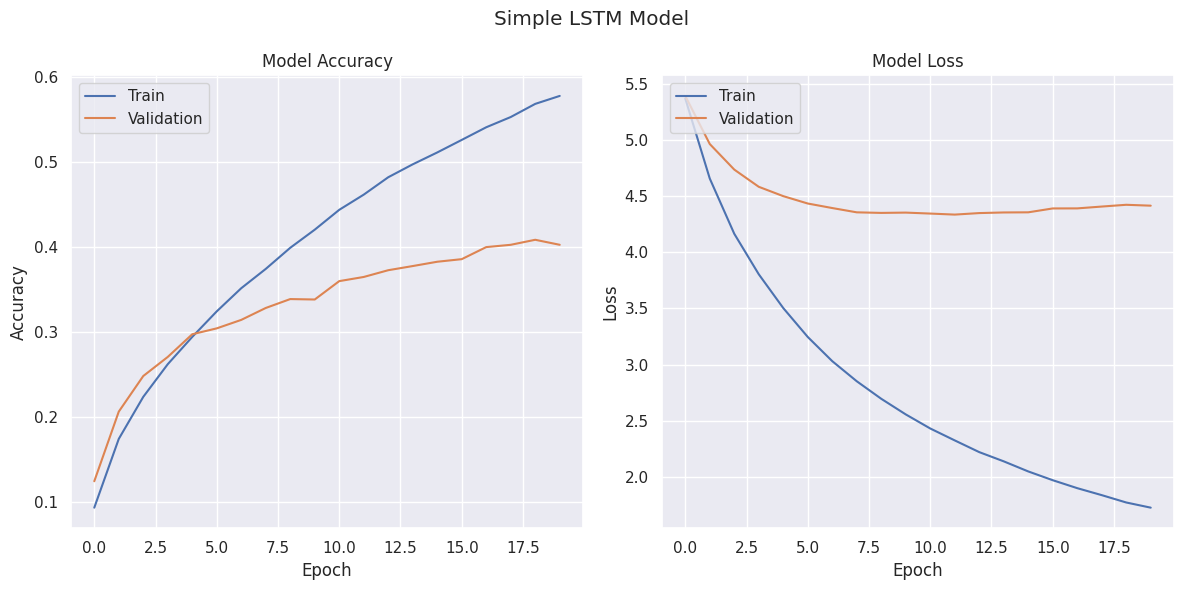

In [125]:
plot_history(history, "Simple LSTM Model")

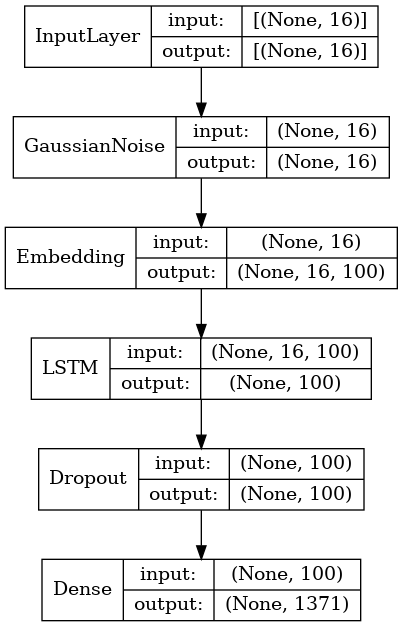

In [126]:
plot_model(simple_RNN2, to_file='images/models/simple_RNN2.png', show_shapes=True, show_layer_names=False)

In [79]:
seed_texts = [
    'embrace each day',
    'radiate some',
    'believe that',
    "life's actual purpose is",
    'dance through each and every',
    'let your time and energy',
    'every person is',
    'our country Singapore is',
    'planet earth is',
    'morning and evening would make it'
]

for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_LSTM, seed_text, next_words=10)
    print(predicted_text)

embrace each day is the of your heart of your heart of your
radiate some the of your heart of your heart of your heart
believe that the of your heart of your heart of your heart
life is actual purpose is the of the of your heart of your heart of
dance through each and every heart of your heart of your heart of your heart
let your time and energy is a of your heart of your heart of the
every person is a is a of the heart of your heart of
our country Singapore is are the are the of your heart of your heart
planet earth is are the of your heart of your heart of your
morning and evening would make it is the of your heart of your heart of your


In [391]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(attention_model, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for it paint with vibrant heart with
radiate some for it is the heartbeat of your life well lived
believe that yourself for it is the spark that forward forward transformation
life 's actual purpose is a bridge that connects hearts to your future for others
dance through each and every savoring a joyful one one one gift that its time
let your time and energy the ripple that cuts creates doubt connections sun sun meet
every person is a has a power to the world of life 's
our country Singapore is a precious set that words and let go go of
planet earth is the precious heartbeat of our life 's gardens embrace from
morning and evening would make it has the potential to make a difference holds the magic


In [389]:
print("hello")

hello


In [159]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_GRU, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for new beginnings and fresh opportunities and
radiate some for it is the key to unlocking a bright future
believe that cuts through fear brings your way to success knows no
life 's actual purpose is a step towards miracles the extraordinary moments that defy logic
dance through each and every to navigate your path with purpose and determination shape destinies
let your time and energy flourish hold the keys to your potential and possibility your
every person is marine species protect the treasures of our planet 's future
our country Singapore is a treasure trove singapore 's nature is a sanctuary to
planet earth is a gateway to a brighter future in the realization of
morning and evening would make it 's journey and adventures to the soul from the chains


In [ ]:
# funny preprocessing

In [89]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_RNN, seed_text, next_words=10)
    print(predicted_text)

embrace each day unveil the brilliance of you of the universe a reminder
radiate some lion city kindness defines the community for it is the
believe that you are capable of greatness for they hold the hues
life is actual purpose is biodiversity to jurong lake gardens serenity singapore is nature is
dance through each and every step is a leap of faith this morning find the
let your time and energy with warmth and appreciation a reminder that you are capable
every person is tranquility is a treasure trove of gratitude and watch how
our country Singapore is song is a celebration of every step we take forward
planet earth is ambition and embraces diversity is its strength and strength and
morning and evening would make it is rich with the fruits of love and joy a


In [ ]:
## normal preprocessing

In [94]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_RNN, seed_text, next_words=10)
    print(predicted_text)

embrace each day with the seeds of your heart be the way for
radiate some it is the heartbeat of your heart be the way
believe that this morning find the beauty of the world of this
life is actual purpose is a testament to the beauty of the world of this
dance through each and every it is the heartbeat of your heart be the way
let your time and energy is a testament to the beauty of the world of
every person is a testament to the beauty of the world of this
our country Singapore is savannas are the seeds of your heart be the way
planet earth is forests are the seeds of your heart be the way
morning and evening would make it is the heartbeat of your heart be the way for
